
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # End of the episodes when the episode is done.
    dones = tf.placeholder(tf.float32, [None], name='dones')

    # Qs = qs+ (gamma * nextQs): targetQs is nextQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, targetQs

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_output(actions, next_states, 
                 state_size, action_size, hidden_size):
    # Generator for nextQs as targetQs
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, _ = generator(prev_actions=actions_onehot, states=next_states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    
    # # Picking the action with the max logits/value/total rewards
    # nextQs_unmasked = tf.reduce_max(axis=1, input_tensor=next_actions_logits)
    # #print('next_actions_logits.shape, nextQs_unmasked.shape:', next_actions_logits.shape, nextQs_unmasked.shape)
    nextQs_unmasked = next_actions_logits
    
    # Returning nextQs unmasked to be masked and used as targetQs/labels
    return nextQs_unmasked

In [14]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss(prev_actions, states, actions, next_states, dones, targetQs,
               state_size, action_size, hidden_size):
    # Generator actions and next states
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_fake
    #actions_predictions = tf.nn.softmax(actions_logits)
    nextQs_fake_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits,
                                         hidden_size=hidden_size)
    
    # Discriminator for nextQs_real
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_real_unmasked = discriminator(prev_actions=actions_onehot, states=next_states,
                                         hidden_size=hidden_size, reuse=True)
    
    # # Masking the unmasked nextQs using dones
    # dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_fake_unmasked.dtype, x=dones)), shape=[-1, 1])
    # nextQs_fake_masked = tf.multiply(nextQs_fake_unmasked, dones_mask)
    # nextQs_real_masked = tf.multiply(nextQs_real_unmasked, dones_mask)
    # nextQs_fake = tf.reduce_max(axis=1, input_tensor=nextQs_fake_masked)
    # nextQs_real = tf.reduce_max(axis=1, input_tensor=nextQs_real_masked)
    print(nextQs_fake_unmasked.shape, nextQs_real_unmasked.shape, targetQs.shape)
    targetQs = tf.reshape(targetQs, [-1, 1])
    
        
    # Adverserial learning/training
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real_unmasked, 
                                                                         labels=tf.zeros_like(targetQs)))
    g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
                                                                         labels=tf.sigmoid(targetQs)))
    # #g_loss_real = tf.reduce_mean(tf.square(nextQs_real - tf.zeros_like(targetQs)))
    # g_loss_real = tf.reduce_mean(tf.square(nextQs_real))
    # g_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - targetQs))
    g_loss = g_loss_real + g_loss_fake

    # Adverserial learning/training
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real_unmasked, 
                                                                         labels=tf.sigmoid(targetQs)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
                                                                         labels=tf.zeros_like(targetQs)))
    # d_loss_real = tf.reduce_mean(tf.square(nextQs_real - targetQs))
    # #d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - tf.zeros_like(targetQs)))
    # d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake))
    d_loss = d_loss_real + d_loss_fake
        
    # Returning the D loss
    return actions_logits, g_loss, d_loss

In [15]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for next state and action prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # action prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [16]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.targetQs = model_input(
            state_size=state_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.nextQs_unmasked = model_output(actions=self.actions, next_states=self.next_states, 
                                            state_size=state_size, action_size=action_size, hidden_size=hidden_size)
        
        # NOTE: Qs will be outputed and targetQs are the Qs used as labels
        self.actions_logits, self.g_loss, self.d_loss = model_loss(targetQs=self.targetQs, dones=self.dones,
                                                                   prev_actions=self.prev_actions, 
                                                                   states=self.states, actions=self.actions,
                                                                   next_states=self.next_states,
                                                                   state_size=state_size, action_size=action_size, 
                                                                   hidden_size=hidden_size)

        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [17]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [21]:
# Training params
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [22]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 1) (?, 1) (?,)


## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [23]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    #train_episodes = 1 # for debugging
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.actions: actions, model.next_states: next_states}
            nextQs_unmasked = sess.run(model.nextQs_unmasked, feed_dict)
            # print('nextQs_unmasked.shape, dones.shape:', 
            #       nextQs_unmasked.shape, dones.shape)

            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_unmasked.dtype)).reshape(-1, 1)
            nextQs_masked = np.multiply(nextQs_unmasked, dones_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            # print('dones_mask.shape, nextQs_masked.shape, nextQs.shape:',
            # dones_mask.shape, nextQs_masked.shape, nextQs.shape)
            targetQs = nextQs#.reshape(-1, 1) # model loss calculation against logits
            #print(targetQs.shape)

            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states,
                         model.dones: dones,
                         model.targetQs: targetQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 34 Training g_loss: 0.7582 Training d_loss: 1.3243 Explore P: 0.9966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 18 Training g_loss: 0.9506 Training d_loss: 1.4162 Explore P: 0.9949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 23 Training g_loss: 1.2505 Training d_loss: 0.9212 Explore P: 0.9926
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 12 Training g_loss: 1.1318 Training d_loss: 0.9303 Explore P: 0.9914
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 34 Total reward: 18 Training g_loss: 0.9464 Training d_loss: 1.2692 Explore P: 0.9273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 7 Training g_loss: 0.9763 Training d_loss: 1.2083 Explore P: 0.9266
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 17 Training g_loss: 1.0697 Training d_loss: 1.1167 Explore P: 0.9251
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 14 Training g_loss: 1.0818 Training d_loss: 1.0538 Explore P: 0.9238
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 67 Total reward: 31 Training g_loss: 1.0302 Training d_loss: 1.1814 Explore P: 0.8744
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 18 Training g_loss: 1.1013 Training d_loss: 1.1428 Explore P: 0.8728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 14 Training g_loss: 0.9665 Training d_loss: 1.2673 Explore P: 0.8716
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 13 Training g_loss: 1.1163 Training d_loss: 1.1336 Explore P: 0.8705
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 100 Total reward: 13 Training g_loss: 0.9144 Training d_loss: 1.2542 Explore P: 0.8319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 12 Training g_loss: 0.9109 Training d_loss: 1.2869 Explore P: 0.8309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 22 Training g_loss: 0.8909 Training d_loss: 1.3023 Explore P: 0.8291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 14 Training g_loss: 0.8377 Training d_loss: 1.3806 Explore P: 0.8280
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 134 Total reward: 21 Training g_loss: 0.8930 Training d_loss: 1.2705 Explore P: 0.7888
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 12 Training g_loss: 0.8816 Training d_loss: 1.2800 Explore P: 0.7879
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 136 Total reward: 12 Training g_loss: 0.8699 Training d_loss: 1.3326 Explore P: 0.7870
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 137 Total reward: 14 Training g_loss: 0.8663 Training d_loss: 1.3027 Explore P: 0.7859
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 168 Total reward: 9 Training g_loss: 0.8574 Training d_loss: 1.3186 Explore P: 0.7482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 13 Training g_loss: 0.9073 Training d_loss: 1.2752 Explore P: 0.7472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 170 Total reward: 10 Training g_loss: 0.9010 Training d_loss: 1.2540 Explore P: 0.7465
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 171 Total reward: 12 Training g_loss: 0.8776 Training d_loss: 1.3117 Explore P: 0.7456
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 201 Total reward: 16 Training g_loss: 0.9123 Training d_loss: 1.2676 Explore P: 0.7161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 10 Training g_loss: 0.8598 Training d_loss: 1.3312 Explore P: 0.7154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 12 Training g_loss: 0.8332 Training d_loss: 1.3914 Explore P: 0.7145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 204 Total reward: 17 Training g_loss: 0.8795 Training d_loss: 1.3310 Explore P: 0.7133
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 234 Total reward: 18 Training g_loss: 0.8671 Training d_loss: 1.3040 Explore P: 0.6861
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 10 Training g_loss: 0.8544 Training d_loss: 1.2951 Explore P: 0.6854
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 236 Total reward: 12 Training g_loss: 0.8620 Training d_loss: 1.2865 Explore P: 0.6846
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 237 Total reward: 10 Training g_loss: 0.8732 Training d_loss: 1.2723 Explore P: 0.6839
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 267 Total reward: 12 Training g_loss: 0.8640 Training d_loss: 1.3311 Explore P: 0.6547
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 10 Training g_loss: 0.8720 Training d_loss: 1.3460 Explore P: 0.6541
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 10 Training g_loss: 0.8534 Training d_loss: 1.3378 Explore P: 0.6534
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 270 Total reward: 7 Training g_loss: 0.8759 Training d_loss: 1.3106 Explore P: 0.6530
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 300 Total reward: 9 Training g_loss: 0.8945 Training d_loss: 1.2797 Explore P: 0.6296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 14 Training g_loss: 0.8675 Training d_loss: 1.3173 Explore P: 0.6288
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 11 Training g_loss: 0.8483 Training d_loss: 1.3297 Explore P: 0.6281
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 14 Training g_loss: 0.8904 Training d_loss: 1.3234 Explore P: 0.6272
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 334 Total reward: 12 Training g_loss: 0.8576 Training d_loss: 1.3165 Explore P: 0.6069
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 14 Training g_loss: 0.8736 Training d_loss: 1.3012 Explore P: 0.6061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 336 Total reward: 17 Training g_loss: 0.8642 Training d_loss: 1.3123 Explore P: 0.6051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 337 Total reward: 8 Training g_loss: 0.8650 Training d_loss: 1.3247 Explore P: 0.6046
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 368 Total reward: 21 Training g_loss: 0.8746 Training d_loss: 1.3086 Explore P: 0.5824
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 7 Training g_loss: 0.8713 Training d_loss: 1.3067 Explore P: 0.5820
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 13 Training g_loss: 0.9065 Training d_loss: 1.2593 Explore P: 0.5813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 13 Training g_loss: 0.8808 Training d_loss: 1.2925 Explore P: 0.5806
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 402 Total reward: 16 Training g_loss: 0.8849 Training d_loss: 1.3395 Explore P: 0.5605
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 403 Total reward: 12 Training g_loss: 0.8429 Training d_loss: 1.4396 Explore P: 0.5598
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 404 Total reward: 12 Training g_loss: 0.8706 Training d_loss: 1.3397 Explore P: 0.5592
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 405 Total reward: 9 Training g_loss: 0.9037 Training d_loss: 1.2824 Explore P: 0.5587
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 436 Total reward: 9 Training g_loss: 0.8972 Training d_loss: 1.2696 Explore P: 0.5362
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 437 Total reward: 20 Training g_loss: 0.8546 Training d_loss: 1.3287 Explore P: 0.5352
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 438 Total reward: 10 Training g_loss: 0.8661 Training d_loss: 1.3359 Explore P: 0.5346
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 439 Total reward: 12 Training g_loss: 0.8944 Training d_loss: 1.3080 Explore P: 0.5340
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 469 Total reward: 10 Training g_loss: 0.8926 Training d_loss: 1.2765 Explore P: 0.5169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 470 Total reward: 11 Training g_loss: 0.8913 Training d_loss: 1.2636 Explore P: 0.5163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 471 Total reward: 19 Training g_loss: 0.8685 Training d_loss: 1.2805 Explore P: 0.5154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 472 Total reward: 8 Training g_loss: 0.8684 Training d_loss: 1.3021 Explore P: 0.5150
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 503 Total reward: 18 Training g_loss: 0.8812 Training d_loss: 1.2875 Explore P: 0.4980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 504 Total reward: 10 Training g_loss: 0.8860 Training d_loss: 1.2962 Explore P: 0.4976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 505 Total reward: 11 Training g_loss: 0.8937 Training d_loss: 1.2938 Explore P: 0.4970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 506 Total reward: 12 Training g_loss: 0.8635 Training d_loss: 1.3312 Explore P: 0.4964
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 537 Total reward: 10 Training g_loss: 0.8657 Training d_loss: 1.3145 Explore P: 0.4811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 538 Total reward: 11 Training g_loss: 0.8771 Training d_loss: 1.3109 Explore P: 0.4806
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 539 Total reward: 9 Training g_loss: 0.8542 Training d_loss: 1.3024 Explore P: 0.4801
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 11 Training g_loss: 0.8864 Training d_loss: 1.2831 Explore P: 0.4796
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 570 Total reward: 15 Training g_loss: 0.8819 Training d_loss: 1.2777 Explore P: 0.4639
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 571 Total reward: 16 Training g_loss: 0.9173 Training d_loss: 1.2917 Explore P: 0.4631
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 572 Total reward: 11 Training g_loss: 0.8830 Training d_loss: 1.3037 Explore P: 0.4626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 573 Total reward: 17 Training g_loss: 0.8410 Training d_loss: 1.3777 Explore P: 0.4619
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 603 Total reward: 7 Training g_loss: 0.8579 Training d_loss: 1.3341 Explore P: 0.4480
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 604 Total reward: 10 Training g_loss: 0.8508 Training d_loss: 1.3464 Explore P: 0.4476
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 605 Total reward: 8 Training g_loss: 0.8544 Training d_loss: 1.3134 Explore P: 0.4472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 606 Total reward: 11 Training g_loss: 0.8631 Training d_loss: 1.2787 Explore P: 0.4467
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 636 Total reward: 9 Training g_loss: 0.8621 Training d_loss: 1.3063 Explore P: 0.4333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 637 Total reward: 9 Training g_loss: 0.8740 Training d_loss: 1.2896 Explore P: 0.4329
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 638 Total reward: 8 Training g_loss: 0.8714 Training d_loss: 1.2862 Explore P: 0.4326
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 639 Total reward: 10 Training g_loss: 0.8791 Training d_loss: 1.2794 Explore P: 0.4322
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 669 Total reward: 15 Training g_loss: 0.9058 Training d_loss: 1.2680 Explore P: 0.4190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 15 Training g_loss: 0.9021 Training d_loss: 1.2567 Explore P: 0.4184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 671 Total reward: 9 Training g_loss: 0.8771 Training d_loss: 1.2869 Explore P: 0.4180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 672 Total reward: 9 Training g_loss: 0.8663 Training d_loss: 1.3276 Explore P: 0.4176
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 702 Total reward: 11 Training g_loss: 0.8491 Training d_loss: 1.3321 Explore P: 0.4039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 703 Total reward: 11 Training g_loss: 0.8398 Training d_loss: 1.3511 Explore P: 0.4035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 704 Total reward: 9 Training g_loss: 0.8522 Training d_loss: 1.3436 Explore P: 0.4031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 705 Total reward: 9 Training g_loss: 0.8551 Training d_loss: 1.3069 Explore P: 0.4028
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 735 Total reward: 7 Training g_loss: 0.9022 Training d_loss: 1.3072 Explore P: 0.3907
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 Total reward: 10 Training g_loss: 0.8662 Training d_loss: 1.3219 Explore P: 0.3903
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 737 Total reward: 9 Training g_loss: 0.8676 Training d_loss: 1.3147 Explore P: 0.3899
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 738 Total reward: 13 Training g_loss: 0.8822 Training d_loss: 1.3210 Explore P: 0.3894
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 768 Total reward: 17 Training g_loss: 0.8867 Training d_loss: 1.2920 Explore P: 0.3783
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 11 Training g_loss: 0.8678 Training d_loss: 1.3191 Explore P: 0.3779
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 9 Training g_loss: 0.8616 Training d_loss: 1.3299 Explore P: 0.3776
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 771 Total reward: 12 Training g_loss: 0.8778 Training d_loss: 1.3173 Explore P: 0.3772
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 802 Total reward: 10 Training g_loss: 0.9269 Training d_loss: 1.2152 Explore P: 0.3657
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 803 Total reward: 7 Training g_loss: 0.9354 Training d_loss: 1.2301 Explore P: 0.3655
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 804 Total reward: 8 Training g_loss: 0.9093 Training d_loss: 1.2510 Explore P: 0.3652
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 805 Total reward: 11 Training g_loss: 0.8644 Training d_loss: 1.3030 Explore P: 0.3648
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 836 Total reward: 9 Training g_loss: 0.8682 Training d_loss: 1.3123 Explore P: 0.3542
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 837 Total reward: 14 Training g_loss: 0.8682 Training d_loss: 1.2962 Explore P: 0.3537
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 838 Total reward: 19 Training g_loss: 0.8602 Training d_loss: 1.3243 Explore P: 0.3530
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 839 Total reward: 7 Training g_loss: 0.8659 Training d_loss: 1.3296 Explore P: 0.3528
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 870 Total reward: 9 Training g_loss: 0.8917 Training d_loss: 1.2886 Explore P: 0.3420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 871 Total reward: 12 Training g_loss: 0.8598 Training d_loss: 1.3283 Explore P: 0.3416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 872 Total reward: 14 Training g_loss: 0.8505 Training d_loss: 1.3328 Explore P: 0.3412
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 873 Total reward: 8 Training g_loss: 0.8896 Training d_loss: 1.3162 Explore P: 0.3409
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 903 Total reward: 9 Training g_loss: 0.8821 Training d_loss: 1.2993 Explore P: 0.3307
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 12 Training g_loss: 0.8821 Training d_loss: 1.2684 Explore P: 0.3303
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 905 Total reward: 9 Training g_loss: 0.8741 Training d_loss: 1.2739 Explore P: 0.3300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 15 Training g_loss: 0.8617 Training d_loss: 1.2954 Explore P: 0.3295
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 937 Total reward: 10 Training g_loss: 0.8477 Training d_loss: 1.3008 Explore P: 0.3198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 12 Training g_loss: 0.8359 Training d_loss: 1.3184 Explore P: 0.3195
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 939 Total reward: 13 Training g_loss: 0.8455 Training d_loss: 1.2962 Explore P: 0.3191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 940 Total reward: 8 Training g_loss: 0.8736 Training d_loss: 1.2596 Explore P: 0.3188
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 971 Total reward: 10 Training g_loss: 0.8602 Training d_loss: 1.3437 Explore P: 0.3094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 972 Total reward: 10 Training g_loss: 0.8481 Training d_loss: 1.3417 Explore P: 0.3091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 973 Total reward: 8 Training g_loss: 0.8727 Training d_loss: 1.2796 Explore P: 0.3089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 974 Total reward: 12 Training g_loss: 0.9009 Training d_loss: 1.2717 Explore P: 0.3085
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1005 Total reward: 11 Training g_loss: 0.9017 Training d_loss: 1.2748 Explore P: 0.2995
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1006 Total reward: 10 Training g_loss: 0.8630 Training d_loss: 1.2928 Explore P: 0.2992
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1007 Total reward: 8 Training g_loss: 0.8707 Training d_loss: 1.3086 Explore P: 0.2990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1008 Total reward: 7 Training g_loss: 0.8627 Training d_loss: 1.3213 Explore P: 0.2988
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1037 Total reward: 10 Training g_loss: 0.8664 Training d_loss: 1.2779 Explore P: 0.2905
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1038 Total reward: 9 Training g_loss: 0.8798 Training d_loss: 1.3182 Explore P: 0.2903
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1039 Total reward: 9 Training g_loss: 0.8495 Training d_loss: 1.3416 Explore P: 0.2900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1040 Total reward: 9 Training g_loss: 0.8550 Training d_loss: 1.3342 Explore P: 0.2898
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1070 Total reward: 10 Training g_loss: 0.8928 Training d_loss: 1.2854 Explore P: 0.2812
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1071 Total reward: 8 Training g_loss: 0.8856 Training d_loss: 1.2634 Explore P: 0.2809
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1072 Total reward: 9 Training g_loss: 0.9111 Training d_loss: 1.2555 Explore P: 0.2807
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1073 Total reward: 7 Training g_loss: 0.8878 Training d_loss: 1.2759 Explore P: 0.2805
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1102 Total reward: 11 Training g_loss: 0.8670 Training d_loss: 1.4363 Explore P: 0.2728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1103 Total reward: 8 Training g_loss: 0.9750 Training d_loss: 1.2739 Explore P: 0.2726
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1104 Total reward: 16 Training g_loss: 1.0259 Training d_loss: 1.2211 Explore P: 0.2722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1105 Total reward: 9 Training g_loss: 0.9786 Training d_loss: 1.2312 Explore P: 0.2719
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1135 Total reward: 9 Training g_loss: 0.8758 Training d_loss: 1.2778 Explore P: 0.2645
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1136 Total reward: 10 Training g_loss: 0.8816 Training d_loss: 1.2807 Explore P: 0.2642
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1137 Total reward: 8 Training g_loss: 0.8747 Training d_loss: 1.2852 Explore P: 0.2640
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1138 Total reward: 8 Training g_loss: 0.8917 Training d_loss: 1.2619 Explore P: 0.2638
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1168 Total reward: 12 Training g_loss: 0.8287 Training d_loss: 1.3201 Explore P: 0.2567
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1169 Total reward: 8 Training g_loss: 0.8726 Training d_loss: 1.3134 Explore P: 0.2565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1170 Total reward: 14 Training g_loss: 0.8790 Training d_loss: 1.2974 Explore P: 0.2561
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1171 Total reward: 8 Training g_loss: 0.8656 Training d_loss: 1.3051 Explore P: 0.2559
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1201 Total reward: 9 Training g_loss: 0.8939 Training d_loss: 1.2822 Explore P: 0.2488
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1202 Total reward: 8 Training g_loss: 0.8571 Training d_loss: 1.2860 Explore P: 0.2486
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1203 Total reward: 9 Training g_loss: 0.8668 Training d_loss: 1.2937 Explore P: 0.2484
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1204 Total reward: 7 Training g_loss: 0.8761 Training d_loss: 1.2932 Explore P: 0.2482
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1233 Total reward: 11 Training g_loss: 0.8548 Training d_loss: 1.3275 Explore P: 0.2416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1234 Total reward: 11 Training g_loss: 0.8710 Training d_loss: 1.3061 Explore P: 0.2413
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1235 Total reward: 10 Training g_loss: 0.8752 Training d_loss: 1.2815 Explore P: 0.2411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1236 Total reward: 9 Training g_loss: 0.8954 Training d_loss: 1.2823 Explore P: 0.2409
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1266 Total reward: 8 Training g_loss: 0.8703 Training d_loss: 1.3156 Explore P: 0.2342
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1267 Total reward: 9 Training g_loss: 0.8629 Training d_loss: 1.3046 Explore P: 0.2340
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1268 Total reward: 8 Training g_loss: 0.8834 Training d_loss: 1.2942 Explore P: 0.2338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1269 Total reward: 9 Training g_loss: 0.8785 Training d_loss: 1.2795 Explore P: 0.2336
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1298 Total reward: 14 Training g_loss: 0.9218 Training d_loss: 1.2439 Explore P: 0.2275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1299 Total reward: 10 Training g_loss: 0.9218 Training d_loss: 1.1762 Explore P: 0.2273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1300 Total reward: 9 Training g_loss: 0.9449 Training d_loss: 1.1817 Explore P: 0.2271
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1301 Total reward: 9 Training g_loss: 0.8848 Training d_loss: 1.2415 Explore P: 0.2269
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1331 Total reward: 9 Training g_loss: 0.8676 Training d_loss: 1.2800 Explore P: 0.2208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1332 Total reward: 10 Training g_loss: 0.8760 Training d_loss: 1.2660 Explore P: 0.2206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1333 Total reward: 12 Training g_loss: 0.8580 Training d_loss: 1.3177 Explore P: 0.2204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1334 Total reward: 8 Training g_loss: 0.8571 Training d_loss: 1.2904 Explore P: 0.2202
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1363 Total reward: 8 Training g_loss: 0.8716 Training d_loss: 1.2969 Explore P: 0.2148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1364 Total reward: 10 Training g_loss: 0.8760 Training d_loss: 1.3002 Explore P: 0.2146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1365 Total reward: 8 Training g_loss: 0.8682 Training d_loss: 1.3031 Explore P: 0.2145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1366 Total reward: 8 Training g_loss: 0.8794 Training d_loss: 1.2944 Explore P: 0.2143
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1395 Total reward: 9 Training g_loss: 0.9407 Training d_loss: 1.2857 Explore P: 0.2085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1396 Total reward: 8 Training g_loss: 0.8940 Training d_loss: 1.2820 Explore P: 0.2083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1397 Total reward: 9 Training g_loss: 0.8796 Training d_loss: 1.3089 Explore P: 0.2081
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1398 Total reward: 10 Training g_loss: 0.8385 Training d_loss: 1.3393 Explore P: 0.2079
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1427 Total reward: 9 Training g_loss: 0.8937 Training d_loss: 1.2892 Explore P: 0.2029
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1428 Total reward: 9 Training g_loss: 0.8393 Training d_loss: 1.3388 Explore P: 0.2028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1429 Total reward: 9 Training g_loss: 0.8378 Training d_loss: 1.3707 Explore P: 0.2026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1430 Total reward: 10 Training g_loss: 0.8366 Training d_loss: 1.3455 Explore P: 0.2024
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1460 Total reward: 10 Training g_loss: 0.9061 Training d_loss: 1.2753 Explore P: 0.1972
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1461 Total reward: 8 Training g_loss: 0.8570 Training d_loss: 1.2630 Explore P: 0.1970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1462 Total reward: 9 Training g_loss: 0.8551 Training d_loss: 1.3423 Explore P: 0.1969
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1463 Total reward: 9 Training g_loss: 0.8441 Training d_loss: 1.3866 Explore P: 0.1967
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1493 Total reward: 9 Training g_loss: 0.9074 Training d_loss: 1.3083 Explore P: 0.1915
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1494 Total reward: 10 Training g_loss: 0.9174 Training d_loss: 1.3071 Explore P: 0.1914
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1495 Total reward: 9 Training g_loss: 0.8945 Training d_loss: 1.2616 Explore P: 0.1912
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1496 Total reward: 9 Training g_loss: 0.9137 Training d_loss: 1.2562 Explore P: 0.1910
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1526 Total reward: 8 Training g_loss: 0.9196 Training d_loss: 1.3206 Explore P: 0.1862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1527 Total reward: 8 Training g_loss: 0.8411 Training d_loss: 1.2631 Explore P: 0.1860
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1528 Total reward: 8 Training g_loss: 0.8962 Training d_loss: 1.2527 Explore P: 0.1859
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1529 Total reward: 11 Training g_loss: 0.9034 Training d_loss: 1.2633 Explore P: 0.1857
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1558 Total reward: 10 Training g_loss: 0.8795 Training d_loss: 1.3084 Explore P: 0.1807
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1559 Total reward: 10 Training g_loss: 0.8384 Training d_loss: 1.4231 Explore P: 0.1806
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1560 Total reward: 8 Training g_loss: 0.8184 Training d_loss: 1.3600 Explore P: 0.1804
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1561 Total reward: 9 Training g_loss: 0.8567 Training d_loss: 1.2882 Explore P: 0.1803
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1591 Total reward: 9 Training g_loss: 0.8453 Training d_loss: 1.3325 Explore P: 0.1757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1592 Total reward: 7 Training g_loss: 0.8332 Training d_loss: 1.3171 Explore P: 0.1755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1593 Total reward: 11 Training g_loss: 0.8474 Training d_loss: 1.4118 Explore P: 0.1754
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1594 Total reward: 8 Training g_loss: 0.8580 Training d_loss: 1.4076 Explore P: 0.1752
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1623 Total reward: 9 Training g_loss: 0.9090 Training d_loss: 1.3008 Explore P: 0.1709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1624 Total reward: 9 Training g_loss: 0.8997 Training d_loss: 1.2796 Explore P: 0.1708
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1625 Total reward: 9 Training g_loss: 0.8742 Training d_loss: 1.2711 Explore P: 0.1706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1626 Total reward: 9 Training g_loss: 0.9976 Training d_loss: 1.1942 Explore P: 0.1705
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1655 Total reward: 10 Training g_loss: 0.8594 Training d_loss: 1.2701 Explore P: 0.1662
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1656 Total reward: 10 Training g_loss: 0.9162 Training d_loss: 1.3287 Explore P: 0.1661
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1657 Total reward: 9 Training g_loss: 0.9131 Training d_loss: 1.2614 Explore P: 0.1659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1658 Total reward: 10 Training g_loss: 0.9299 Training d_loss: 1.2188 Explore P: 0.1658
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1688 Total reward: 9 Training g_loss: 0.9069 Training d_loss: 1.2710 Explore P: 0.1616
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1689 Total reward: 8 Training g_loss: 0.8643 Training d_loss: 1.2921 Explore P: 0.1615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1690 Total reward: 9 Training g_loss: 0.8332 Training d_loss: 1.3120 Explore P: 0.1613
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1691 Total reward: 10 Training g_loss: 0.9035 Training d_loss: 1.2427 Explore P: 0.1612
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1720 Total reward: 10 Training g_loss: 0.8387 Training d_loss: 1.2808 Explore P: 0.1571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1721 Total reward: 9 Training g_loss: 0.9820 Training d_loss: 1.2796 Explore P: 0.1569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1722 Total reward: 9 Training g_loss: 0.9434 Training d_loss: 1.2561 Explore P: 0.1568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1723 Total reward: 9 Training g_loss: 0.9107 Training d_loss: 1.2090 Explore P: 0.1567
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1753 Total reward: 9 Training g_loss: 0.9101 Training d_loss: 1.2495 Explore P: 0.1525
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1754 Total reward: 11 Training g_loss: 0.9648 Training d_loss: 1.2510 Explore P: 0.1524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1755 Total reward: 8 Training g_loss: 0.8871 Training d_loss: 1.2728 Explore P: 0.1523
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1756 Total reward: 9 Training g_loss: 0.8850 Training d_loss: 1.2361 Explore P: 0.1521
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1786 Total reward: 9 Training g_loss: 0.9414 Training d_loss: 1.1107 Explore P: 0.1483
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1787 Total reward: 8 Training g_loss: 0.9462 Training d_loss: 1.2898 Explore P: 0.1482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1788 Total reward: 9 Training g_loss: 0.8837 Training d_loss: 1.3587 Explore P: 0.1481
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1789 Total reward: 10 Training g_loss: 0.8314 Training d_loss: 1.4178 Explore P: 0.1480
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1818 Total reward: 8 Training g_loss: 0.9834 Training d_loss: 1.2076 Explore P: 0.1444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1819 Total reward: 9 Training g_loss: 0.9960 Training d_loss: 1.2066 Explore P: 0.1443
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1820 Total reward: 9 Training g_loss: 1.0082 Training d_loss: 1.1953 Explore P: 0.1441
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1821 Total reward: 8 Training g_loss: 0.8584 Training d_loss: 1.1893 Explore P: 0.1440
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1850 Total reward: 8 Training g_loss: 0.9351 Training d_loss: 1.1883 Explore P: 0.1407
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1851 Total reward: 9 Training g_loss: 0.8979 Training d_loss: 1.1949 Explore P: 0.1406
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1852 Total reward: 9 Training g_loss: 0.9316 Training d_loss: 1.2264 Explore P: 0.1404
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1853 Total reward: 9 Training g_loss: 0.9750 Training d_loss: 1.2248 Explore P: 0.1403
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1883 Total reward: 9 Training g_loss: 0.9419 Training d_loss: 1.2947 Explore P: 0.1369
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1884 Total reward: 7 Training g_loss: 0.8819 Training d_loss: 1.3099 Explore P: 0.1368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1885 Total reward: 11 Training g_loss: 0.9011 Training d_loss: 1.3501 Explore P: 0.1366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1886 Total reward: 8 Training g_loss: 0.8684 Training d_loss: 1.3264 Explore P: 0.1365
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1915 Total reward: 9 Training g_loss: 0.8410 Training d_loss: 1.4638 Explore P: 0.1334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1916 Total reward: 8 Training g_loss: 0.9288 Training d_loss: 1.3250 Explore P: 0.1333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1917 Total reward: 9 Training g_loss: 1.0212 Training d_loss: 1.1255 Explore P: 0.1332
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1918 Total reward: 9 Training g_loss: 1.2157 Training d_loss: 1.1023 Explore P: 0.1331
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1947 Total reward: 9 Training g_loss: 0.9029 Training d_loss: 1.2567 Explore P: 0.1298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1948 Total reward: 12 Training g_loss: 0.9366 Training d_loss: 1.2009 Explore P: 0.1297
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1949 Total reward: 10 Training g_loss: 0.9265 Training d_loss: 1.2089 Explore P: 0.1295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1950 Total reward: 10 Training g_loss: 0.9749 Training d_loss: 1.2498 Explore P: 0.1294
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1979 Total reward: 8 Training g_loss: 0.9474 Training d_loss: 1.2138 Explore P: 0.1264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1980 Total reward: 9 Training g_loss: 1.0953 Training d_loss: 1.1648 Explore P: 0.1263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1981 Total reward: 10 Training g_loss: 0.9804 Training d_loss: 1.2122 Explore P: 0.1262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1982 Total reward: 9 Training g_loss: 1.0588 Training d_loss: 1.2450 Explore P: 0.1261
-------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

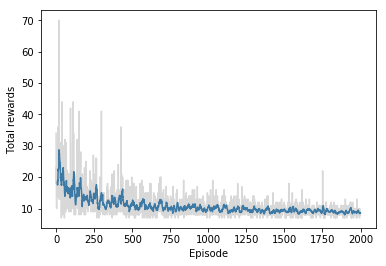

In [26]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

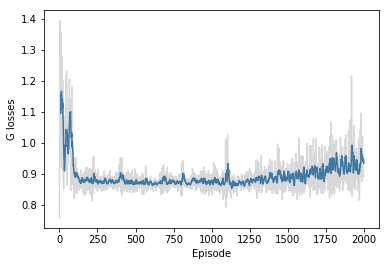

In [27]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

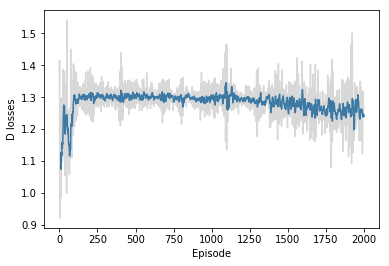

In [28]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.